Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 1

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin with baselines: majority class baseline for classification, or mean baseline for regression, with your metric of choice.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?

## Reading

### ROC AUC
- [Machine Learning Meets Economics](http://blog.mldb.ai/blog/posts/2016/01/ml-meets-economics/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)
- [The philosophical argument for using ROC curves](https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/)

### Imbalanced Classes
- [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
- [Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/)

### Last lesson
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [How Shopify Capital Uses Quantile Regression To Help Merchants Succeed](https://engineering.shopify.com/blogs/engineering/how-shopify-uses-machine-learning-to-help-our-merchants-grow-their-business)
- [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)

# Transit Systems of the World

We will be predicting the future station closures for New York City

### Imports

In [ ]:
# !pip install jupyterlab==1.0 "ipywidgets==7.5"

# If needed install the above. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import pylab as pl
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot

### Loading data

In [2]:
cities = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/cities.csv')
lines = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/lines.csv')
station_lines = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/station_lines.csv')
stations = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/stations.csv')
systems = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/systems.csv')
tracklines = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/track_lines.csv')
tracks = pd.read_csv('https://raw.githubusercontent.com/stefanoruiz/datasets/master/transit-systems-of-the-world/tracks.csv')

### Data Preprocessing

These datasets involve a bit a cleaning. When using *geopandas* or *plotly.mapbox* you need the latitude and longitude to be separate. As is, using *pysal.contrib.viz* mapping feature we could plot without cleaning and separating the data. In this case we will be using Plotly library to plot the station on the map.

In [3]:
stations.columns=['id','stations_name','geometry','buildstart','opening','closure','city_id']
stations['Longitude']=stations['geometry'].apply(lambda x: x.split('POINT(')[1].split(' ')[0])
stations['Latitude']=stations['geometry'].apply(lambda x: x.split('POINT(')[1].split(' ')[1].split(')')[0])

In [4]:
# Dropping geometry since it is a redundant feature.
stations = stations.drop(columns='geometry')

id_country = pd.DataFrame({'city_id':cities.id,'country':cities.country,'name':cities.name})
stations=pd.merge(stations,id_country)

In [5]:
stations['Latitude'] = stations['Latitude'].astype(str).astype(float)
stations['Longitude'] = stations['Longitude'].astype(str).astype(float)

stations.dtypes

id                 int64
stations_name     object
buildstart       float64
opening          float64
closure          float64
city_id            int64
Longitude        float64
Latitude         float64
country           object
name              object
dtype: object

,id,stations_name,buildstart,opening,closure,city_id,Longitude,Latitude,country,name
15784,13634,Coligny,1998.0,2000.0,999999.0,308,1.900368,47.916025,France,Orleans
15785,13635,Coligny,1998.0,2000.0,999999.0,308,1.900329,47.916023,France,Orleans
15786,13636,Gare d'Orléans,1998.0,2000.0,999999.0,308,1.905209,47.906775,France,Orleans
15787,13632,Gare des Aubrais,1998.0,2000.0,999999.0,308,1.906959,47.926515,France,Orleans
15788,13633,Gare des Aubrais,1998.0,2000.0,999999.0,308,1.907002,47.926523,France,Orleans
15789,13637,Gare d'Orléans,1998.0,2000.0,999999.0,308,1.905217,47.906798,France,Orleans
15790,13638,NaN,1998.0,200.0,999999.0,308,1.902857,47.901442,France,Orleans
15791,13639,NaN,1998.0,2000.0,999999.0,308,1.902839,47.901058,France,Orleans
15792,16473,NaN,0.0,0.0,999999.0,72,-2.236667,53.480156,England,Manchester
15793,16474,NaN,0.0,0.0,999999.0,72,-2.237354,53.480418,England,Manchester


## Visualizing the top 5 stations by city

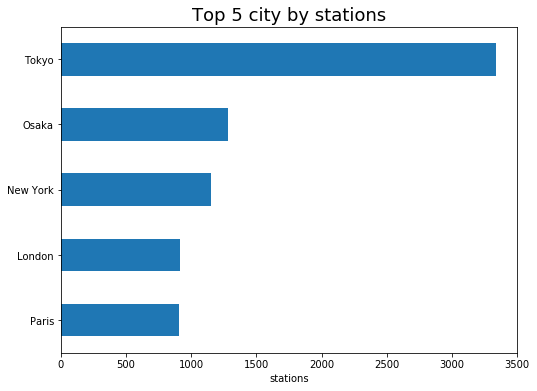

In [14]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1) 
stations.name.value_counts()[:5].sort_values().plot.barh()
plt.title("Top 5 city by stations",size=18)
plt.xlabel("stations")

plt.show();

In [15]:
ny_stations = stations.dropna(subset=['closure','name','opening'])
ny_stations = stations[stations.closure>=9999]
ny_stations = stations[stations.opening>0]
ny_stations = stations[stations.opening<=2030]

ny_lines = lines[lines.city_id == 206]
ny_tracklines = tracklines[tracklines.city_id == 206]
ny_tracks = tracks[tracks.city_id == 206].drop(columns=['buildstart','opening','closure','city_id'])

ny_tracks.columns = ['section_id','geometry','length']
ny_tracklines = pd.merge(ny_tracklines, ny_tracks)
ny_tracklines = ny_tracklines.drop(columns=['id','created_at','updated_at','city_id'])

ny_tracklines.columns = ['section_id','id','geometry','length']
ny_lines = pd.merge(ny_tracklines, ny_lines)
ny_stations = stations[stations['city_id'] == 206]

ny_stations.head()





,id,stations_name,buildstart,opening,closure,city_id,Longitude,Latitude,country,name
5138,13713,Sands Street,1888.0,1888.0,1944.0,206,-73.990060,40.699996,United States,New York
5139,13712,Sands Street,1888.0,1888.0,1940.0,206,-73.990920,40.700003,United States,New York
5140,13715,Franklin Avenue,1896.0,1896.0,99999.0,206,-73.955829,40.680937,United States,New York
5141,13714,Bedford,1878.0,1878.0,1896.0,206,-73.956053,40.679158,United States,New York
5142,13717,Dean Street,1896.0,1896.0,1995.0,206,-73.956499,40.677780,United States,New York


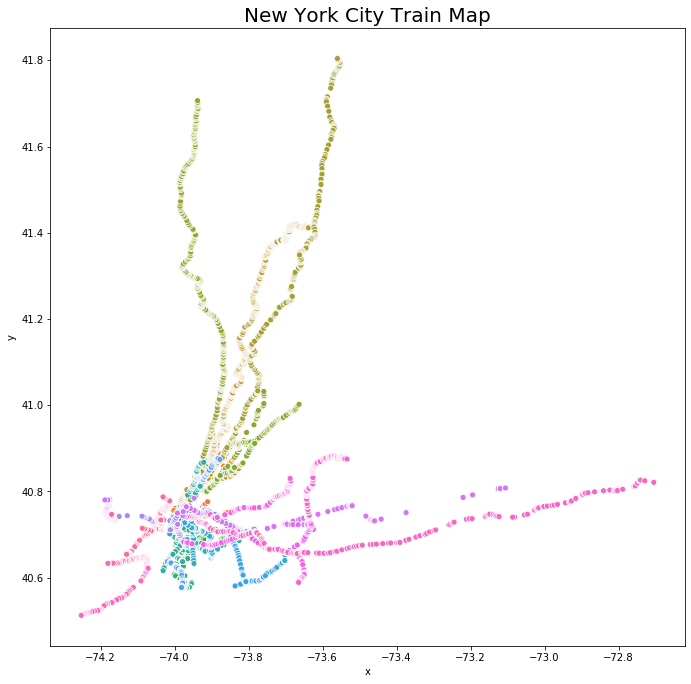

In [17]:
x=[]
y=[]
z=[]

for i in range(len(ny_lines)):
    sp = ny_lines.iloc[i].geometry.split('(')[1].split(')')[0].split(',')
    for j in range(len(sp)):
        x.append(sp[j].split(' ')[0])
        y.append(sp[j].split(' ')[1])
        z.append(ny_lines.url_name[i])

plot_lines=pd.DataFrame({'x':x,'y':y,'z':z})
plot_lines['x'] = plot_lines['x'].astype(float)
plot_lines['y'] = plot_lines['y'].astype(float)

plt.figure(figsize=(25, 25))
plt.subplot(2, 2, 1) 
ax=sns.scatterplot(x="x", y="y", hue="z",data=plot_lines)
plt.legend(loc=0, bbox_to_anchor=(1.05,0.6))
plt.title("New York City Train Map",size=20)
ax.get_legend().remove()

In [26]:
# If I ever get a mapbox to work, I'll go ahead and uncomment this. 

# px.set_mapbox_access_token(open(".mapbox_token").read())
# fig = px.scatter_mapbox(ny_stations, lat="Latitude", lon="Longitude", color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
# fig.show()

FileNotFoundError: [Errno 2] No such file or directory: '.mapbox_token'

In [27]:
from sklearn.model_selection import train_test_split

In [41]:
# Target 
features = ['opening', 'buildstart', 'Longitude', 'Latitude']
target = 'closure'

X = ny_stations[features]
y = ny_stations[target]

In [42]:
X.head()

,opening,buildstart,Longitude,Latitude
5138,1888.0,1888.0,-73.990060,40.699996
5139,1888.0,1888.0,-73.990920,40.700003
5140,1896.0,1896.0,-73.955829,40.680937
5141,1878.0,1878.0,-73.956053,40.679158
5142,1896.0,1896.0,-73.956499,40.677780


In [48]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42)


In [49]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (645, 4)
y_train shape (645,)
X_val shape (216, 4)
y_val shape (216,)
X_test shape (287, 4)
y_test shape (287,)


In [50]:
pd.options.display.float_format = None

In [54]:
y_train.value_counts(normalize=True);

In [60]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels

from sklearn.metrics import confusion_matrix

majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
print('Baseline score: ', accuracy_score(y_val, y_pred))

Baseline score:  0.6574074074074074


In [64]:
confusion_matrix(y_val, y_pred)

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,